<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Open_Water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Open_Water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # SAR Application: Open Water
### I. How to create SAR images of open water?
* Useful Products: HH, HV, VV power (backscatter); Intensity images (HH, VV, and HV). Pauli Decomposition images for quad-pol or HH/HV, VV/VH for dual-pol images.
* Useful Wavelengths: L, S, C, X, Ku (?)
* Relevant Sensors: UAVSAR, Sentinel-1, ALOS, JERS-1, ERS, TandemX
* Qualitative Browse Products: Open water delineation


### II. How to interpret SAR images of open water?
In PolSAR images, open water areas appear darker or black due to surface or specular scattering off a flat surface. Other flat areas such as roads or air strips can appear "radar smooth" as well. However, they are usually not as dark as calm water, and different thresholds and polarizations can be leveraged to set thresholds to create an open water mask.

Uninhabited Aerial Vehicle Synthetic Aperture Radar (UAVSAR) is an L-Band airborne radar instrument mounted on NASA's C-20A research aircraft. The overlay of different polarization channels allows users to visually classify a scene by its backscattering mechanism, such as surface scattering (strong HH and VV return), volume scattering (strong HV return) and double-bounce scattering (strong HH return). Thus in RGB images, areas dominated by green (HV) intensity are typically vegetated areas. Areas dominated by shades of pink (HH+HV) intensity are typically inundated forests, vegetated fields, or urban areas. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is relatively lower radar backscatter.  

## SAR Example: Panama Canal
This notebook explores UAVSAR data over open water and agricultural fields in Panama. Click on the underlined titles below to navigate to their section. The content of this notebook is as follows:

1. [Running the Notebook](#s1)
2. [UAVSAR Panama Canal RGB](#s2)
3. [HH Channel Thresholding](#s3)
4. [Comparing HH, and VV Polarizations](#s4)
5. [HH / VV Ratio](#s5)
6. [Water Map](#s6)



<a name="s1"></a>
## 1. Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- Code cells that are required for the notebook to run without errors are marked numerically with <font color='red'> Run cell below </font> 

### Python Packages:
This routine using the following python libaries. Some are already included in the Google Colab environment and others are installed in the cell below. Downloading new python packages to this environment may take a few minutes to complete.

<font color='red'> 1. Run cell below </font> 

In [ ]:
!pip install rasterio --quiet

import rasterio as rio         # Read and write geospatial raster data
import rasterio.plot            # Plotting
from rasterio.plot import show  # Plotting
import matplotlib.pyplot as plt # Plotting, making graphs
import numpy as np              # Numeric and mathematic functions
import math                     # Access to mathematical functions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 55.4 MB/s eta 0:00:00


### Download the Data

Fetch UAVSAR geotiffs from the download links below with wget. The original UAVSAR data have been converted to cropped and subset geotiffs.

<font color='red'> 2. Run cell below </font> 

In [ ]:
# First read in data from JPL website
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Open_Water/PCanal_31504_10017_010_100206_L090HHHH_CX_02_cropped.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Open_Water/PCanal_31504_10017_010_100206_L090VVVV_CX_02_cropped.grd.tif --quiet

<a name="s3"></a>
## 3. HH Polarization Thresholding

A simple water mask can be generated by thresholding SAR images. Below, the UAVSAR images are converted to decibels from linear power. Then, a histogram is plotted of the dB values to determine a binary threshold, such that open water are values below the threshold and values above the threshold are classified as land. 

The HH polarization is preferred for smoooth open water surface detection and HV for rough water surface (Mahoney, 2020). 

Read in UAVSAR geotiffs and convert to decibels (dB)

<font color='red'> 3. Run cell below </font> 

In [ ]:
# Read in geotiffs
def read_file(path):
  with rio.open(path) as ds:
    band = ds.read(1)
    return band

# Convert to decibels (dB)
def convert_db(data):
    db = 10*(math.log10(data))
    return db
convert_db2 = np.vectorize(convert_db)

panamaHH = read_file('PCanal_31504_10017_010_100206_L090HHHH_CX_02_cropped.grd.tif')
panama_db_HH = convert_db2(panamaHH)

Plot UAVSAR HH image

<font color='red'> 4. Run cell below </font> 

Text(0.5, 1.0, 'Panama HH dB')

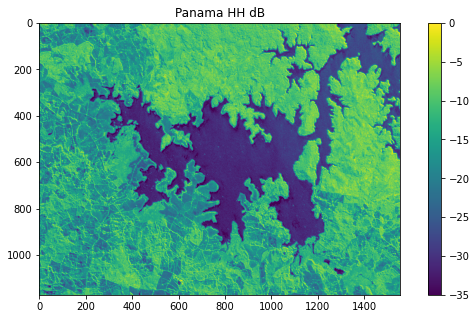

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(panama_db_HH, vmin=-35, vmax=0)
plt.colorbar()
plt.title('Panama HH dB')

To view the value distribution, generate histogram of frequency of backscatter (dB). Below see histogram of UAVSAR subset in Panama. The vertical lines mark the threshold values applied in the next step.

<font color='red'> 5. Run cell below </font> 

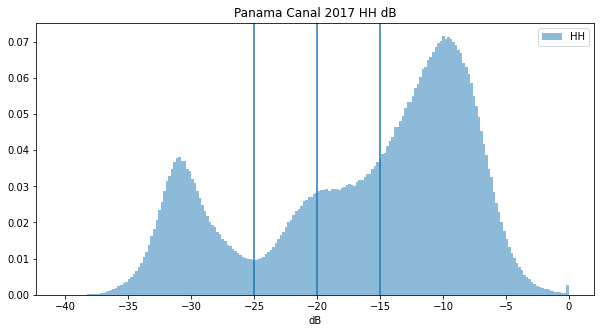

In [ ]:
## Histogram
n = 200
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(np.clip(panama_db_HH.ravel(),-50,0), density=True, bins=n, alpha=0.5, label='HH')
ax.set_title('Panama Canal 2017 HH dB')
ax.legend(prop={'size': 10})
ax.set_xlabel('dB')

# Threshold values below
xpoints = [-25, -20, -15]
for p in xpoints:

    plt.axvline(p,  label='threshold values')
plt.show()

plt.show()

Based upon the image's histogram, we apply different threshold values to the Panama HH Image.

The image's histogram has a bimodal distribution, with a distinction at -25 dB. Using -25 as a threshold, open water is largely separated from the surrounding forests and open fields. As the threshold is increased to -20 and -15, more open fields or agricultural areas are included with open water. In this example, open agricultural fields also show lower dB values, especially relative to the forested area in the northern portion of the image. However, the open water area still has lower dB values.

<font color='red'> 6. Run cell below </font> 

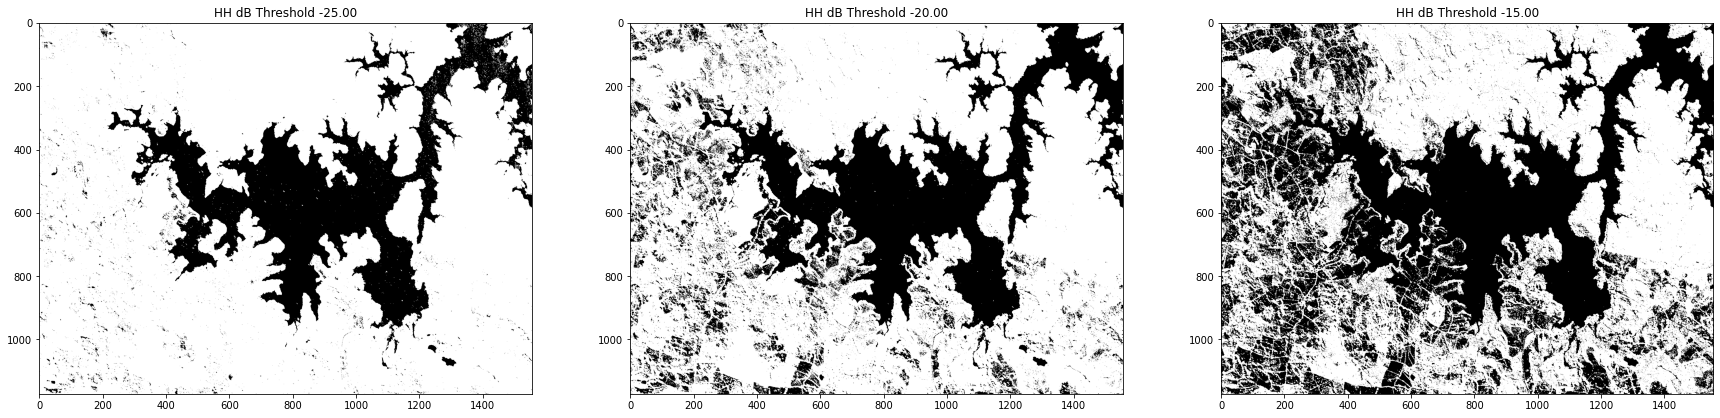

In [ ]:
## Thresholding
N=3
thresh_arr = np.linspace(-25, -15, N)
fig, ax = plt.subplots(1, N, figsize=(30, 15))
for ax, thresh in zip(ax.ravel(), thresh_arr):
    ax.imshow(panama_db_HH < thresh, cmap="Greys")
    ax.set_title(f'HH dB Threshold {thresh:1.2f}')

<a name="s4"></a>
## 4. Comparing HH and VV Polarizations

Culter et. al 2015 found "cross-pol (i.e. HV or VH) often provides better contrast for segmentation of open-water and non-open-water than the HH polarization." This study explores examples where cross pol provides better open-water classification accuracy than HH, such situations of 'over radiation" from urban features that may affect the HH polarization and not HV. 

"SAR water detection studies typically use HH polarization based on a 2006 study by Henry et al.The study by Henry et al. used a limited number of Envisat and ERS images to demonstrate higher contrast in HH than HV and VV."


HH, VV and the cross-pol HV interact differently with open water areas. This section plots these three polarizations to compare. Below, VV and HV are first read into the notebook.

<font color='red'> 7. Run cell below </font> 

In [ ]:
panamaVV = read_file('PCanal_31504_10017_010_100206_L090VVVV_CX_02_cropped.grd.tif')
panama_db_VV = convert_db2(panamaVV)

Next, plot HH, VV, and HV histograms and images.

<font color='red'> 8. Run cell below </font> 

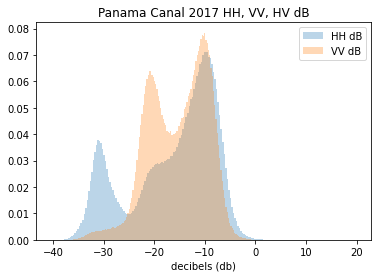

In [ ]:
### Plot histogram of full image or select areas
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=200, density=True)

plt.hist(panama_db_HH.flatten(), **kwargs, label='HH dB')
plt.hist(panama_db_VV.flatten(), **kwargs, label='VV dB')
# plt.hist(panama_db_HV.flatten(), **kwargs, label='HV db');

plt.xlabel('decibels (db)')
plt.ylabel('')
plt.title('Panama Canal 2017 HH, VV, HV dB')
plt.legend(prop={'size': 10})

<font color='red'> 9. Run cell below </font> 

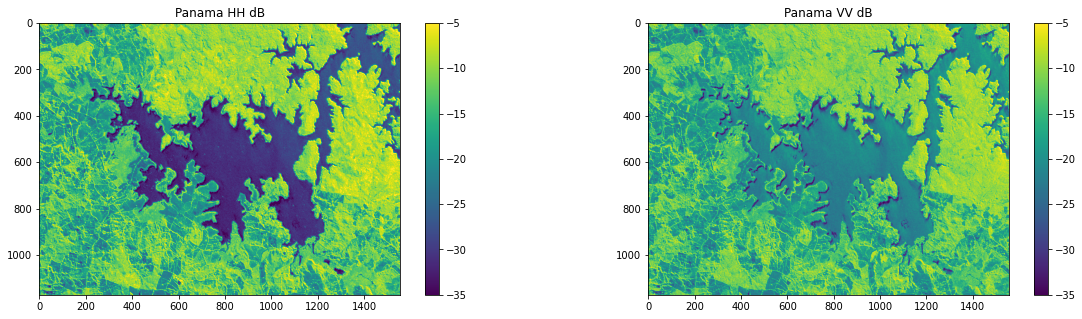

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
HH_db = ax[0].imshow(panama_db_HH, vmin=-35, vmax=-5) 
ax[0].set_title('Panama HH dB')
fig.colorbar(HH_db, ax=ax[0])

VV_db = ax[1].imshow(panama_db_VV, vmin=-35, vmax=-5) 
ax[1].set_title('Panama VV dB')
fig.colorbar(VV_db, ax=ax[1])

<a name="s5"></a>
## 5. HH / VV Ratio

Another combination explored in the literature, is the HH/VV ratio.

From Kim et. al 2016: "A threshold of -3 dB applied to the HH/VV polarization ratio is found effective in detecting water bodies at 40° incidence angle based on analysis of theoretical model predictions and measurements from airborne synthetic aperture radar and the spaceborne Aquarius scatterometer. When the water surface is calm and its radar response is very small (i.e., at the radar thermal noise level), the HH/VV ratio method fails. However, a combination of an HH/VV threshold (at -3 dB) and an HH threshold (at -25 dB) is shown to allow water body classification even in this situation."

<font color='red'> 10. Run cell below </font> 

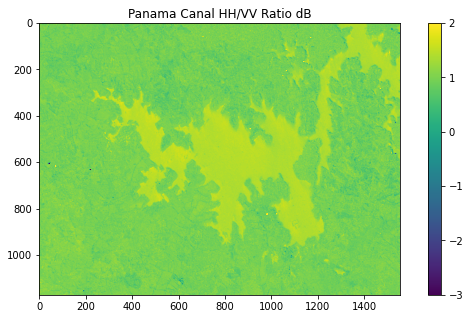

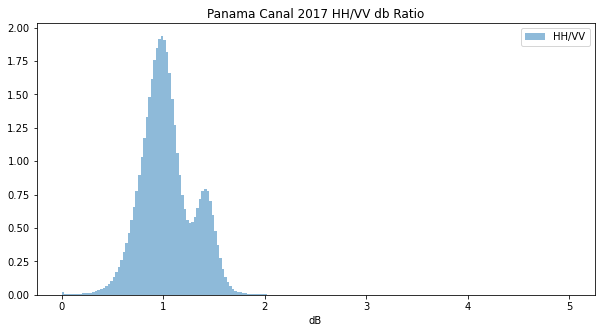

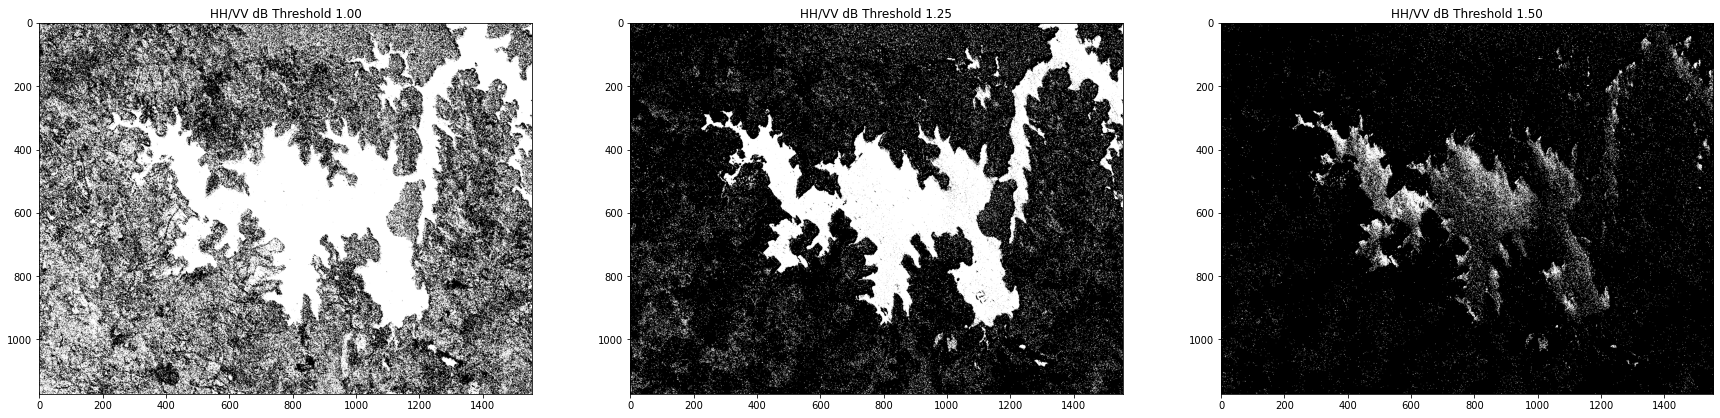

In [ ]:
ratio = panama_db_HH/panama_db_VV

fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(ratio, vmin=-3, vmax=2)
plt.colorbar()
plt.title('Panama Canal HH/VV Ratio dB')

## Histogram
n = 200
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(np.clip(ratio.ravel(),0,5), density=True, bins=n, alpha=0.5, label='HH/VV')
ax.set_title('Panama Canal 2017 HH/VV db Ratio')
ax.legend(prop={'size': 10})
ax.set_xlabel('dB')

plt.show()

## Thresholding
N=3
thresh_arr = np.linspace(1, 1.5, N)
fig, ax = plt.subplots(1, N, figsize=(30, 15))
for ax, thresh in zip(ax.ravel(), thresh_arr):
    ax.imshow(ratio < thresh, cmap="Greys")
    ax.set_title(f'HH/VV dB Threshold {thresh:1.2f}')

<a name="s6"></a>
## 6. Water mask / simple classification

## Data Download

UAVSAR Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

ASF: https://search.asf.alaska.edu/#/

## Other Resources

## References

Kim, S., Ouellette, J.D., van Zyl, J.J. Johnson, J.T. (2016). Detection of Inland Open Water Surfaces Using Dual Polarization L-Band Radar for the Soil Moisture Active Passive Mission. IEEE Transactions on Geoscience and Remote Sensing 54, 3388-3399. DOI: 10.1109/TGRS.2016.2517010

Cutler, P.J., Schwartzkopf, W.C. & Koehler, F.W. (2015). Robust automated thresholding of SAR imagery for open-water detection. 2015 IEEE Radar Conference (RadarCon). DOI: 10.1109/RADAR.2015.7131015

Mahoney, C., Merchant, M., Boychuk, L., Hopkinson, C. & Brisco, B. (2020). Automated SAR Image Thresholds for Water Mask Production in Alberta’s Boreal Region. Remote Sensing 12, 2223. DOI: 10.3390/rs12142223

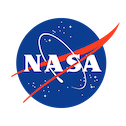

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2021. California Institute of Technology. Government sponsorship acknowledged. 